# 04. Evaluation & Results
 
This notebook evaluates the trained GAT-GAE/HAN-GAE models for functional clustering in Liverpool.

In [ ]:
"""
# Colab setup (optional)
!git clone https://github.com/c2g-dev/city2graph-case-study.git

import os
REPO_DIR = "/content/city2graph-case-study"
os.chdir(REPO_DIR)

# delete data directory
!rm -rf /content/city2graph-case-study/data

# download data zip from Zenodo and unzip into data/
!wget -O /content/city2graph-case-study/data.zip https://zenodo.org/records/18396286/files/data.zip?download=1
!unzip -o /content/city2graph-case-study/data.zip -d /content/city2graph-case-study/

!pip install torch_geometric
!pip install city2graph

os.chdir(REPO_DIR + "/notebooks")
"""

## 1. Setup & Configuration

In [2]:
import sys, os
sys.path.append(os.path.abspath('..'))

import yaml
import torch
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import contextily

import city2graph as c2g
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from libpysal.weights import Queen
from esda.moran import Moran

# Load config
with open('../configs/experiment_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Set seeds
np.random.seed(config['seeds']['global'])
torch.manual_seed(config['seeds']['global'])

# Paths
DATA_ROOT = config['data']['root']
EMBEDDINGS_DIR = '../data/outputs/embeddings'
FIGURES_DIR = '../data/outputs/figures'
TABLES_DIR = '../data/outputs/tables'
CLUSTERS_DIR = '../data/outputs/clusters'

for d in [FIGURES_DIR, TABLES_DIR, CLUSTERS_DIR]:
    os.makedirs(d, exist_ok=True)

# Model configurations
MODELS = {
    'Baseline': {'file': f"../{DATA_ROOT}/{config['data']['homo']}", 'type': 'baseline'},
    'Model 1 (GAT-GAE)': {'file': f"{EMBEDDINGS_DIR}/model1_gat_gae.pt", 'type': 'homo'},
    'Model 2 (HAN-GAE: Walk)': {'file': f"{EMBEDDINGS_DIR}/model2_han_gae_walk.pt", 'type': 'hetero'},
    'Model 3 (HAN-GAE: Multi)': {'file': f"{EMBEDDINGS_DIR}/model3_han_gae_multi.pt", 'type': 'hetero'},
    'Model 4 (HAN-GAE: All)': {'file': f"{EMBEDDINGS_DIR}/model4_han_gae_all.pt", 'type': 'hetero'}
}

# Embedding dimensions and beta dimensions per model
EMBEDDING_COLS = [f'embedding_{i}' for i in range(16)]

# Update to capture both Layer 1 and Layer 2 betas
BETA_COLS = {
    'Model 2 (HAN-GAE: Walk)': [f'beta1_{i}' for i in range(2)] + [f'beta2_{i}' for i in range(2)],
    'Model 3 (HAN-GAE: Multi)': [f'beta1_{i}' for i in range(2)] + [f'beta2_{i}' for i in range(2)],
    'Model 4 (HAN-GAE: All)': [f'beta1_{i}' for i in range(3)] + [f'beta2_{i}' for i in range(3)]
}

RELATION_NAMES = {
    'Model 2 (HAN-GAE: Walk)': ['contig', '15_min_walk'],
    'Model 3 (HAN-GAE: Multi)': ['contig', '15_min_multi'],
    'Model 4 (HAN-GAE: All)': ['contig', '15_min_walk', '15_min_multi']
}

K_RANGE = range(2, 31)
CITY_CENTRE = {'lat': 53.403553, 'lon': -2.986844}  # Liverpool One

## 2. Load Embeddings & Convert to GeoDataFrames

In [3]:
# Load OA polygons for geometry mapping
oa_polygons = gpd.read_file('../data/processed/features/oa_with_features.gpkg').set_index('OA21CD')

# Dictionary to store GeoDataFrames with embeddings
model_gdfs = {}
attention_data = {}

for model_name, meta in MODELS.items():
    print(f"\nLoading: {model_name}")
    data = torch.load(meta['file'], map_location='cpu', weights_only=False)

    # Validate the PyG object
    c2g.validate_pyg(data)

    # Determine additional columns to extract
    if meta['type'] == 'baseline':
        # Baseline: use raw features (x tensor), no embeddings stored
        nodes_gdf, _ = c2g.pyg_to_gdf(data, node_types='oa')
        # For baseline, the features are in x - we'll handle this separately
        model_gdfs[model_name] = nodes_gdf

    elif meta['type'] == 'homo':
        # Homogeneous model: extract embedding columns
        nodes_gdf, _ = c2g.pyg_to_gdf(data, additional_node_cols=EMBEDDING_COLS)
        model_gdfs[model_name] = nodes_gdf

    else:  # hetero
        # Heterogeneous model: extract embeddings and beta weights for 'oa' node type
        add_cols = {'oa': EMBEDDING_COLS + BETA_COLS.get(model_name, [])}
        node_gdfs, _ = c2g.pyg_to_gdf(data, node_types=['oa'], additional_node_cols=add_cols)
        nodes_gdf = node_gdfs['oa']
        model_gdfs[model_name] = nodes_gdf

        # Store beta columns for attention analysis
        if model_name in BETA_COLS:
            rels = RELATION_NAMES[model_name]
            n_rels = len(rels)
            
            # Layer 1
            cols1 = [f'beta1_{i}' for i in range(n_rels)]
            beta1_df = nodes_gdf[cols1].copy()
            beta1_df.columns = rels
            
            # Layer 2
            cols2 = [f'beta2_{i}' for i in range(n_rels)]
            beta2_df = nodes_gdf[cols2].copy()
            beta2_df.columns = rels
            
            attention_data[model_name] = {'Layer 1': beta1_df, 'Layer 2': beta2_df}

    # Replace geometry with OA polygons for choropleth mapping
    model_gdfs[model_name] = model_gdfs[model_name].set_geometry(
        oa_polygons.loc[model_gdfs[model_name].index, 'geometry']
    )

    print(f"  Loaded {len(model_gdfs[model_name])} OAs")


Loading: Baseline
  Loaded 1624 OAs

Loading: Model 1 (GAT-GAE)
  Loaded 1624 OAs

Loading: Model 2 (HAN-GAE: Walk)
  Loaded 1624 OAs

Loading: Model 3 (HAN-GAE: Multi)
  Loaded 1624 OAs

Loading: Model 4 (HAN-GAE: All)
  Loaded 1624 OAs


## 3. Clustering Pipeline

For each model:
1. L2-normalize embeddings
2. Search for optimal K using Silhouette score
3. Run K-Means with multiple seeds for stability
4. Save best clustering results

In [4]:
def get_embeddings(gdf, model_type):
    """Extract embedding matrix from GeoDataFrame."""
    if model_type == 'baseline':
        # Use raw feature columns (all numeric except geometry)
        feat_cols = [c for c in gdf.columns if c not in ['geometry'] and gdf[c].dtype in ['float64', 'float32', 'int64']]
        return gdf[feat_cols].values
    else:
        return gdf[EMBEDDING_COLS].values

def optimal_k_clustering(Z, k_range, n_seeds=10, base_seed=42):
    """Find optimal K and run stable clustering."""
    Z_norm = normalize(Z, norm='l2')

    # K search
    k_scores = []
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=base_seed, n_init=10)
        labels = km.fit_predict(Z_norm)
        k_scores.append({
            'k': k,
            'silhouette': silhouette_score(Z_norm, labels)
        })

    k_df = pd.DataFrame(k_scores)
    best_k = int(k_df.loc[k_df['silhouette'].idxmax(), 'k'])

    # Multi-seed stability
    results = []
    for i in range(n_seeds):
        km = KMeans(n_clusters=best_k, random_state=base_seed + i, n_init=10)
        labels = km.fit_predict(Z_norm)
        results.append({
            'labels': labels,
            'silhouette': silhouette_score(Z_norm, labels)
        })

    best = max(results, key=lambda x: x['silhouette'])
    return {
        'k': best_k,
        'labels': best['labels'],
        'silhouette': best['silhouette'],
        'silhouette_std': np.std([r['silhouette'] for r in results]),
        'k_search': k_df
    }

# Run clustering for all models
clustering_results = {}

for model_name, gdf in model_gdfs.items():
    print(f"\nClustering: {model_name}")
    Z = get_embeddings(gdf, MODELS[model_name]['type'])
    result = optimal_k_clustering(Z, K_RANGE, n_seeds=10, base_seed=config['seeds']['clustering'])

    # Add cluster labels to GeoDataFrame
    gdf['cluster'] = result['labels']
    clustering_results[model_name] = result

    # Save cluster assignments
    safe_name = model_name.lower().replace(' ', '_').replace('(', '').replace(')', '')
    gdf[['cluster']].to_csv(f"{CLUSTERS_DIR}/{safe_name}_kmeans.csv")

    print(f"  K={result['k']}, Silhouette={result['silhouette']:.4f}")


Clustering: Baseline
  K=2, Silhouette=0.2017

Clustering: Model 1 (GAT-GAE)
  K=2, Silhouette=0.2663

Clustering: Model 2 (HAN-GAE: Walk)
  K=27, Silhouette=0.4400

Clustering: Model 3 (HAN-GAE: Multi)
  K=19, Silhouette=0.4358

Clustering: Model 4 (HAN-GAE: All)
  K=25, Silhouette=0.4585


## 3.5 Cluster Statistics (Table 2)
Display the range (min-max) of each index by clusters.

In [5]:
data = {}
metrics_info = {
    'silhouette': {'name': 'Silhouette Score', 'fmt': '.4f'}
}

for model_name, result in clustering_results.items():
    k_df = result['k_search']
    data[model_name] = {}
    
    for col, info in metrics_info.items():
        # Calculate stats
        mean_val = k_df[col].mean()
        std_val = k_df[col].std()
        
        min_idx = k_df[col].idxmin()
        max_idx = k_df[col].idxmax()
        
        min_val = k_df.loc[min_idx, col]
        min_k = int(k_df.loc[min_idx, 'k'])
        
        max_val = k_df.loc[max_idx, col]
        max_k = int(k_df.loc[max_idx, 'k'])
        
        # Populate nested dictionary for MultiIndex columns
        # (Top Level, Sub Level)
        data[model_name][(info['name'], 'Mean ± SD')] = f"{mean_val:{info['fmt']}} ± {std_val:{info['fmt']}}"
        data[model_name][(info['name'], 'Min (k)')] = f"{min_val:{info['fmt']}} (k={min_k})"
        data[model_name][(info['name'], 'Max (k)')] = f"{max_val:{info['fmt']}} (k={max_k})"

# Create DataFrame from dict (keys=Models -> Rows)
df_results_range = pd.DataFrame(data).T
# Set column names for MultiIndex
df_results_range.columns.names = ['Metric', 'Statistic']

display(df_results_range)
df_results_range.to_csv(f"{TABLES_DIR}/cluster_stats_mean_std.csv")

Metric                   Silhouette Score                              
Statistic                       Mean ± SD        Min (k)        Max (k)
Baseline                  0.1429 ± 0.0132  0.1260 (k=28)   0.2012 (k=2)
Model 1 (GAT-GAE)         0.1610 ± 0.0258  0.1304 (k=27)   0.2663 (k=2)
Model 2 (HAN-GAE: Walk)   0.3795 ± 0.0547   0.2725 (k=4)  0.4400 (k=27)
Model 3 (HAN-GAE: Multi)  0.4089 ± 0.0291   0.3044 (k=2)  0.4358 (k=19)
Model 4 (HAN-GAE: All)    0.4087 ± 0.0554   0.2545 (k=2)  0.4571 (k=25)

## 3.6 Cluster Chart

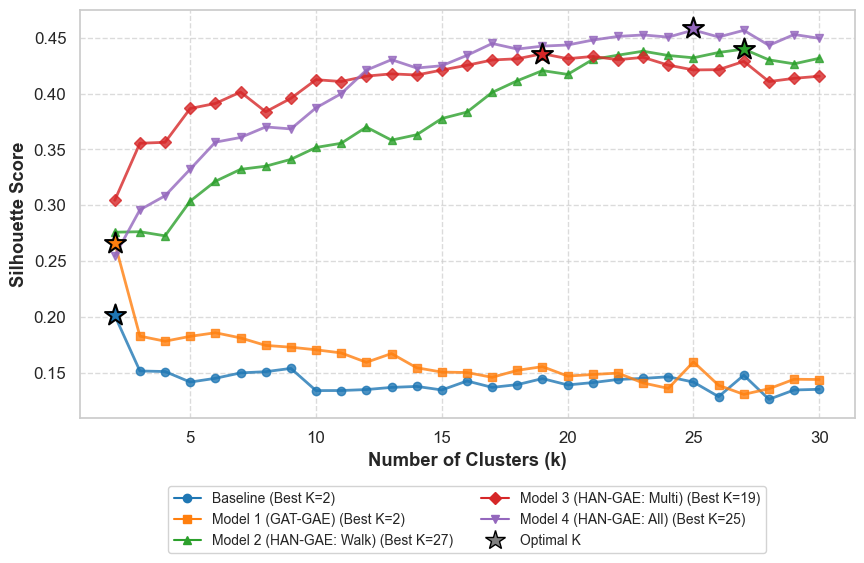

In [6]:
# Plot Silhouette Score only (Legend Fixed)
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better aesthetics
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)

fig, ax = plt.subplots(figsize=(10, 6))

# Distinct colors for models
colors = sns.color_palette("tab10", n_colors=len(clustering_results))
markers = ['o', 's', '^', 'D', 'v']

for idx, (model_name, result) in enumerate(clustering_results.items()):
    k_df = result['k_search']
    
    # Plot line
    ax.plot(k_df['k'], k_df['silhouette'], 
            marker=markers[idx % len(markers)], 
            color=colors[idx], 
            label=model_name, 
            linewidth=2, markersize=6, alpha=0.8)
    
    # Mark best K
    best_k = result['k']
    best_score = result['silhouette']
    
    # Add star
    ax.scatter([best_k], [best_score], s=250, marker='*', 
               color=colors[idx], edgecolors='black', linewidth=1.5, zorder=10)

ax.set_xlabel('Number of Clusters (k)', fontweight='bold')
ax.set_ylabel('Silhouette Score', fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.7)

# Custom Legend outside of the plot axis
from matplotlib.lines import Line2D
legend_elements = []
for idx, model_name in enumerate(clustering_results.keys()):
    legend_elements.append(Line2D([0], [0], color=colors[idx], 
                                  marker=markers[idx % len(markers)], 
                                  label=f"{model_name} (Best K={clustering_results[model_name]['k']})"))

legend_elements.append(Line2D([0], [0], marker='*', color='w', label='Optimal K', 
                              markerfacecolor='gray', markersize=15, markeredgecolor='k'))

# Place legend below the plot
ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=2, frameon=True, fontsize=10, facecolor='white', framealpha=1, edgecolor='lightgray')

plt.subplots_adjust(bottom=0.2) # Make room for legend
plt.savefig(f"{FIGURES_DIR}/silhouette.png", dpi=300, bbox_inches='tight')
plt.show()

## 6. Cluster Map Visualizations using c2g.plot_graph

In [7]:
# Refactored Helper Functions
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import to_hex
from shapely.geometry import Point
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.patches import Patch
import pyproj

def get_centre_coords(gdf, lat, lon):
    """Transform city centre to GDF CRS."""
    if gdf.crs and gdf.crs != 'EPSG:4326':
        transformer = pyproj.Transformer.from_crs('EPSG:4326', gdf.crs, always_xy=True)
        return transformer.transform(lon, lat)
    return lon, lat

def find_city_centre_oa(gdf, centre_lat, centre_lon):
    """Find the OA containing or nearest to the city centre."""
    cx, cy = get_centre_coords(gdf, centre_lat, centre_lon)
    pt = Point(cx, cy)
    
    # Check containment (vectorized)
    # We use 'geometry' column. Note: gdf should be a GeoDataFrame.
    hits = gdf[gdf.geometry.contains(pt)]
    if not hits.empty:
        return hits.index[0]
        
    # Fallback to nearest neighbor
    return gdf.geometry.distance(pt).idxmin()

def get_cluster_centroid_similarities(embeddings, labels, oa_index, centre_oa_idx):
    """Compute cosine similarity between city centre cluster centroid and others."""
    # Create DataFrame for easier grouping
    df = pd.DataFrame(embeddings)
    df['label'] = labels
    
    # Identify target cluster
    try:
        centre_pos = list(oa_index).index(centre_oa_idx)
        target_label = labels[centre_pos]
    except (ValueError, KeyError, IndexError):
        print("Warning: City centre OA not found, defaulting to label 0")
        target_label = 0
    
    # Compute centroids
    centroids_df = df.groupby('label').mean()
    centroids = centroids_df.values
    cluster_labels = centroids_df.index.values
    
    # Target centroid
    if target_label in centroids_df.index:
        target_centroid = centroids_df.loc[target_label].values.reshape(1, -1)
    else:
        # Fallback if somehow missing
        target_centroid = centroids[0].reshape(1, -1)
    
    sims = cosine_similarity(target_centroid, centroids)[0]
    return dict(zip(cluster_labels, sims))

def map_continuous_to_colors(values, cmap_name='RdYlBu_r', vmin=None, vmax=None):
    """Map continuous values to colors using matplotlib normalization."""
    cmap = plt.get_cmap(cmap_name)
    if vmin is None: vmin = values.min()
    if vmax is None: vmax = values.max()
    
    # Use Normalize which handles singular ranges gracefully (maps to 0.0)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    
    # If all values are the same, Normalize might map to 0.5 or 0 depending on implementation details
    # but usually safe.
    
    return [to_hex(cmap(norm(v))) for v in values], vmin, vmax

# Find the city centre OA
centre_oa_idx = find_city_centre_oa(model_gdfs['Model 1 (GAT-GAE)'], 
                                     CITY_CENTRE['lat'], CITY_CENTRE['lon'])
print(f"City centre OA: {centre_oa_idx}")


City centre OA: E00176629


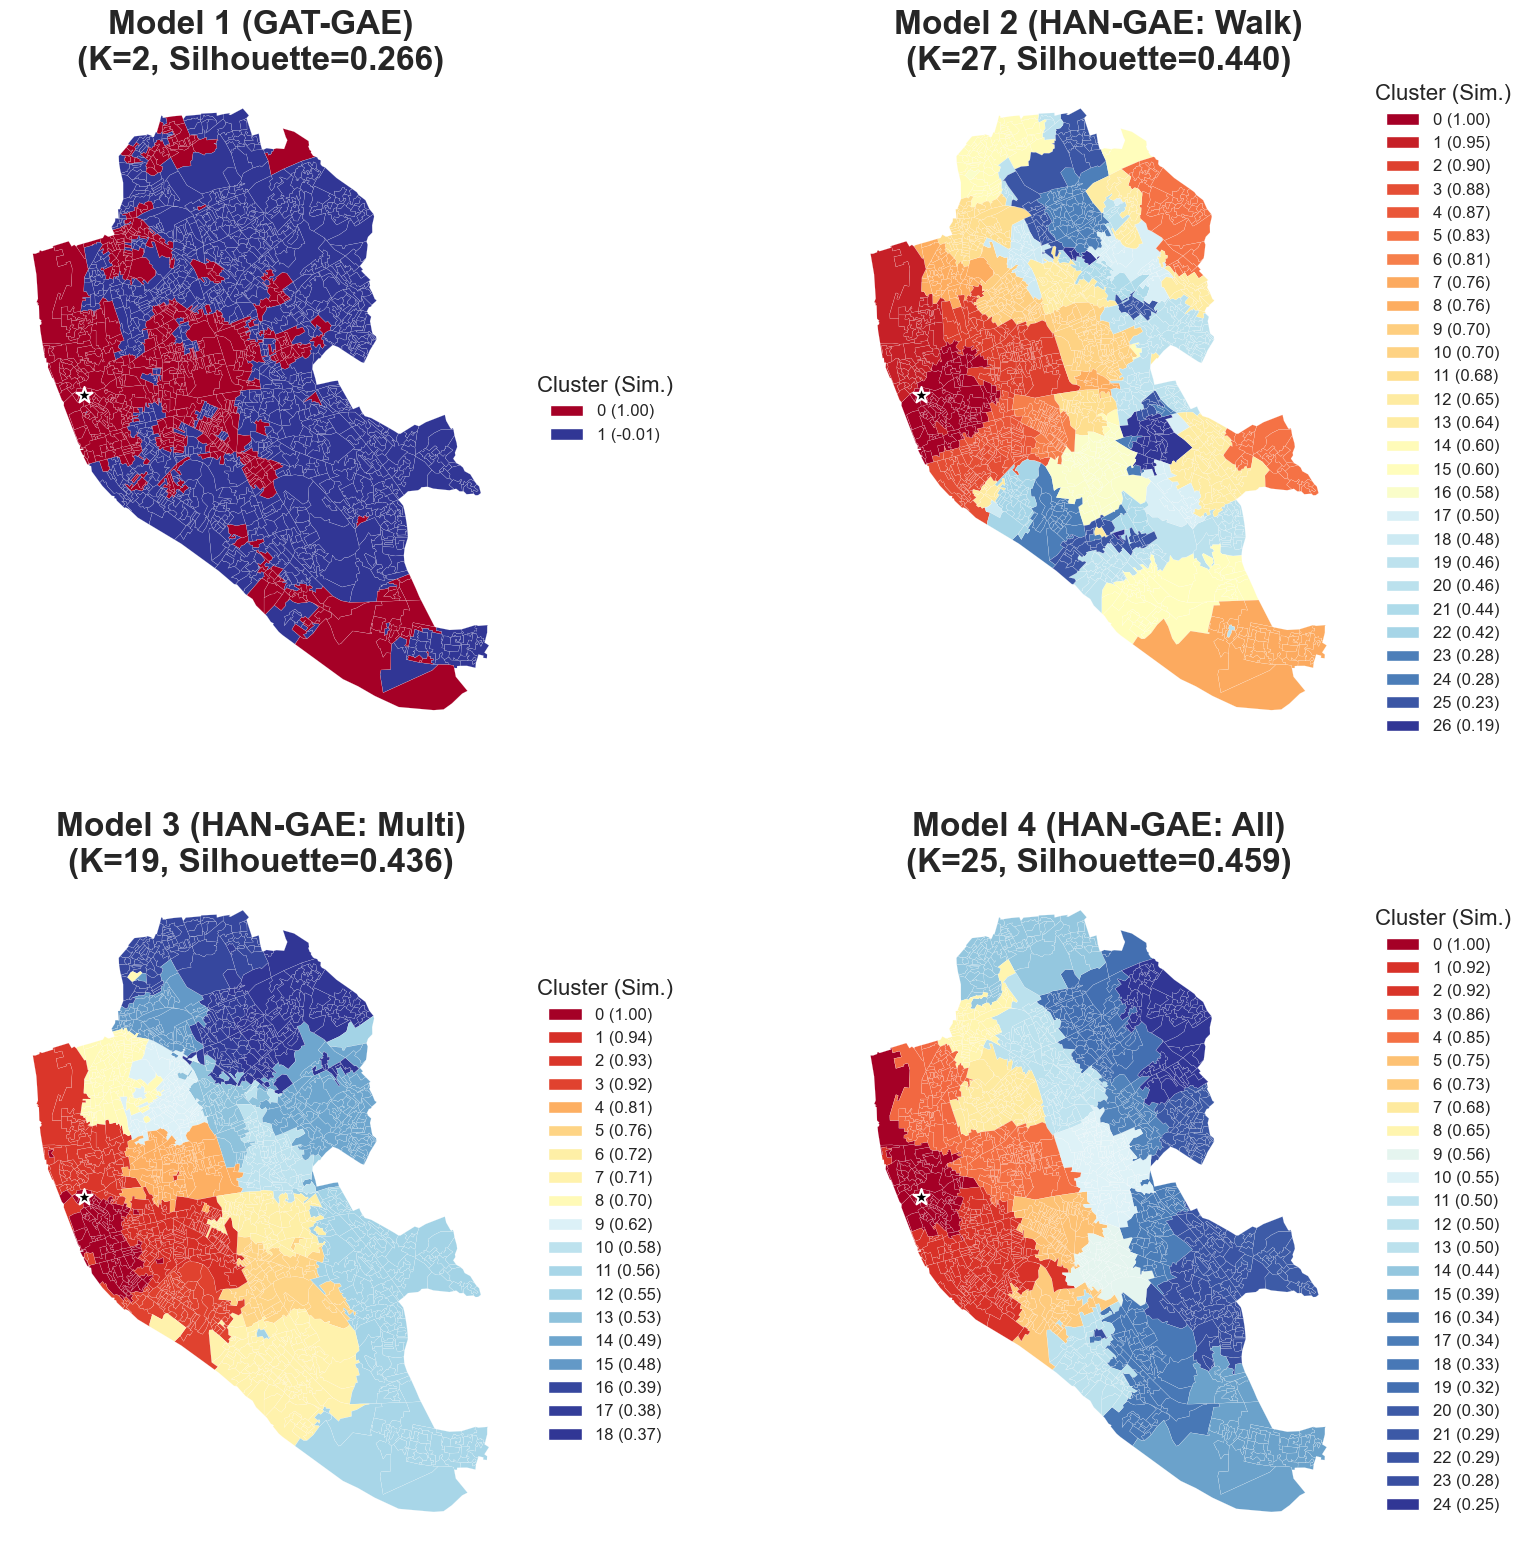

In [8]:
# 2x2 Panel: Cluster Maps for Models 1-4
fig, axes = plt.subplots(2, 2, figsize=(18, 16))
models_to_plot = ['Model 1 (GAT-GAE)', 'Model 2 (HAN-GAE: Walk)', 'Model 3 (HAN-GAE: Multi)', 'Model 4 (HAN-GAE: All)']

for idx, model_name in enumerate(models_to_plot):
    ax = axes[idx // 2, idx % 2]
    gdf = model_gdfs[model_name]
    result = clustering_results[model_name]
    
    # Get embeddings and normalize
    Z = get_embeddings(gdf, MODELS[model_name]['type'])
    Z_norm = normalize(Z, norm='l2')
    
    # Calculate similarities of cluster centroids to the target cluster centroid\n    # Use raw embeddings (Z) to calculate the mean of multivariate space
    cluster_sims = get_cluster_centroid_similarities(
        Z, result['labels'], gdf.index, centre_oa_idx
    )
    
    # Re-order labels so that label 0 is most similar to centre, etc.
    sorted_old_labels = sorted(cluster_sims.keys(), key=lambda l: cluster_sims[l], reverse=True)
    old_to_new_label = {old: new for new, old in enumerate(sorted_old_labels)}
    
    # Assign new label and similarity to each node
    node_new_labels = np.array([old_to_new_label[l] for l in result['labels']])
    node_sim_values = np.array([cluster_sims[l] for l in result['labels']])
    
    # Map these values to colors
    node_colors, vmin, vmax = map_continuous_to_colors(node_sim_values, cmap_name='RdYlBu_r')
    
    # Create legend elements using NEW labels
    # We iterate through the new labels (0, 1, 2...) which correspond to sorted_old_labels
    legend_elements = []
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap('RdYlBu_r')
    
    for new_label in range(len(sorted_old_labels)):
        old_label = sorted_old_labels[new_label]
        sim = cluster_sims[old_label]
        color = to_hex(cmap(norm(sim)))
        
        legend_elements.append(Patch(facecolor=color, edgecolor='white', 
                                     label=f"{new_label} ({sim:.2f})"))
    
    # Use c2g.plot_graph with mapped colors
    c2g.plot_graph(
        nodes=gdf,
        ax=ax,
        node_color=node_colors,
        node_edgecolor='white',
        node_alpha=1,
        linewidth=0.1,
        bgcolor='white',
    )
    
    # Mark city centre
    cx, cy = get_centre_coords(gdf, CITY_CENTRE['lat'], CITY_CENTRE['lon'])
    ax.scatter([cx], [cy], c='black', s=150, marker='*', zorder=5, 
               edgecolors='white', linewidths=1.5)
    
    ncol = 1
    
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.02, 0.5),
              fontsize=12, title='Cluster (Sim.)', title_fontsize=16, 
              frameon=False, ncol=ncol)
    
    ax.set_title(f"{model_name}\n(K={result['k']}, Silhouette={result['silhouette']:.3f})", 
                 fontsize=24, fontweight='bold')
    ax.set_axis_off()

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/cluster_maps.png", dpi=300, bbox_inches='tight')
plt.show()

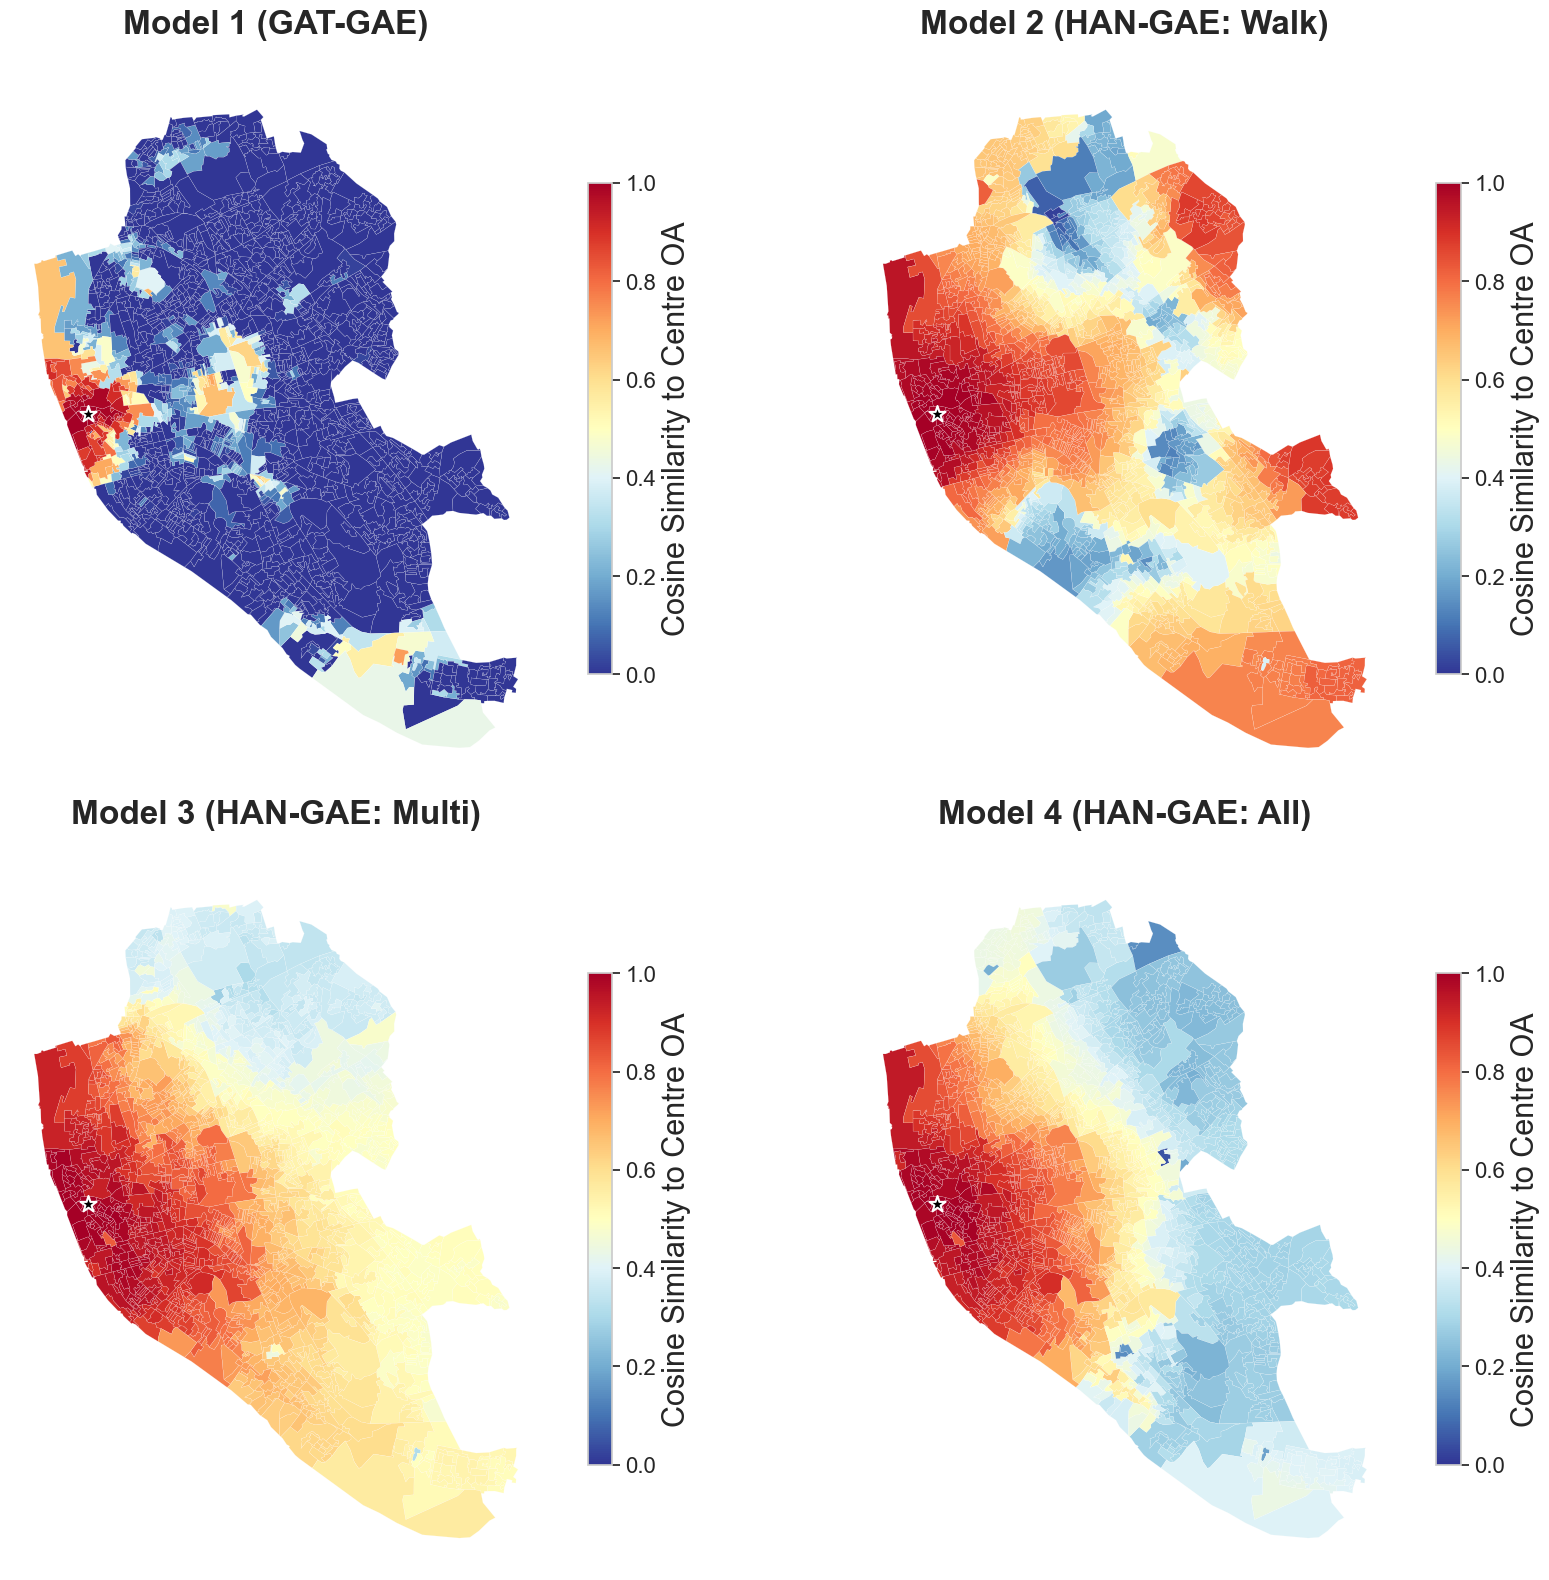

In [9]:
def compute_embedding_similarity_to_centre(embeddings, oa_index, centre_oa_idx):
    """
    Compute cosine similarity between city centre OA embedding and all others.
    Returns array of similarities (1 = identical to centre, 0 = orthogonal).
    """
    from sklearn.metrics.pairwise import cosine_similarity
    
    # Get the position of centre OA in the array
    centre_pos = list(oa_index).index(centre_oa_idx)
    centre_embedding = embeddings[centre_pos:centre_pos+1]  # Keep 2D
    
    # Compute cosine similarity with all embeddings
    similarities = cosine_similarity(centre_embedding, embeddings)[0]
    
    return similarities

# 2x2 Panel of Similarity Maps (Models 1-4) - colored by embedding similarity to centre
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

for idx, model_name in enumerate(models_to_plot):
    ax = axes[idx // 2, idx % 2]
    gdf = model_gdfs[model_name]
    result = clustering_results[model_name]
    
    # Get embeddings and normalize
    Z = get_embeddings(gdf, MODELS[model_name]['type'])
    Z_norm = normalize(Z, norm='l2')
    
    # Compute similarity to city centre
    similarities = compute_embedding_similarity_to_centre(Z_norm, gdf.index, centre_oa_idx)
    
    # Map similarity values to colors (red = high similarity, blue = low)
    node_colors, _, _ = map_continuous_to_colors(similarities, cmap_name='RdYlBu_r', vmin=0, vmax=1)
    
    # Use c2g.plot_graph with similarity-based colors
    c2g.plot_graph(
        nodes=gdf,
        ax=ax,
        node_color=node_colors,
        node_edgecolor='white',
        node_alpha=1,
        linewidth=0.1,
        bgcolor='white',
    )
    
    # Mark city centre
    cx, cy = get_centre_coords(gdf, CITY_CENTRE['lat'], CITY_CENTRE['lon'])
    ax.scatter([cx], [cy], c='black', s=150, marker='*', zorder=5, 
               edgecolors='white', linewidths=1.5)
    
    # Add colorbar for similarity scale
    sm = plt.cm.ScalarMappable(cmap='RdYlBu_r', norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
    cbar.set_label('Cosine Similarity to Centre OA', fontsize=22)
    cbar.ax.tick_params(labelsize=16)
    
    ax.set_title(f"{model_name}\n", fontsize=24, fontweight='bold')
    ax.set_axis_off()

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'cluster_maps_similarity.png'), dpi=300, bbox_inches='tight')
plt.show()

## 7. Attention Heatmap using c2g.plot_graph

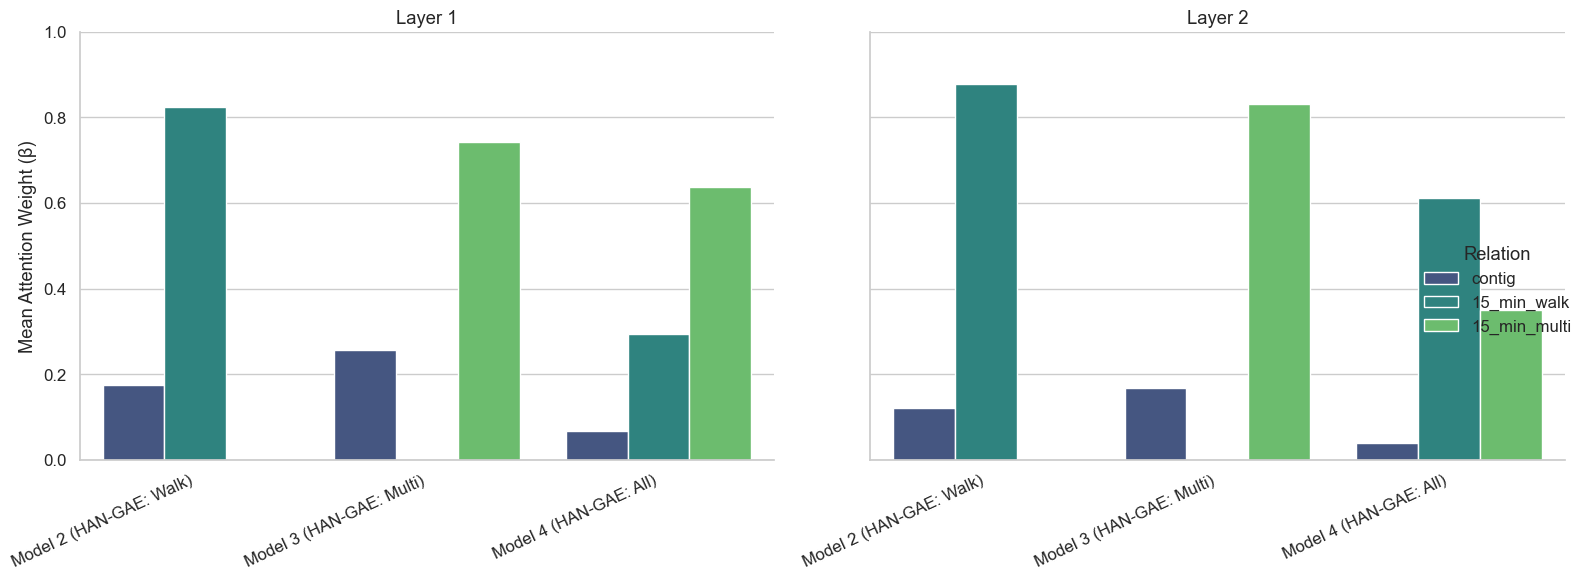

In [10]:
# Compute attention summary from attention_data
attention_summary = []
for model_name, layers_data in attention_data.items():
    for layer_name, beta_df in layers_data.items():
        for rel in beta_df.columns:
            attention_summary.append({
                'Model': model_name,
                'Layer': layer_name,
                'Relation': rel,
                'Mean β': beta_df[rel].mean(),
                'Std β': beta_df[rel].std()
            })

# Bar chart of mean semantic attention per relation
if len(attention_summary) > 0:
    df_att = pd.DataFrame(attention_summary)
    
    # Create a faceted plot: Rows=Layer, X=Model, Hue=Relation
    g = sns.catplot(
        data=df_att, 
        kind="bar", 
        x="Model", 
        y="Mean β", 
        hue="Relation", 
        col="Layer",
        palette="viridis",
        height=6, 
        aspect=1.2,
        legend_out=True
    )
    
    g.set_axis_labels("", "Mean Attention Weight (β)")
    g.set_titles("{col_name}")
    g.set(ylim=(0, 1))
    
    # Rotate x-axis labels for better visibility
    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(25)
            label.set_ha('right')
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'attention_bar.png'), dpi=150, bbox_inches='tight')
    plt.show()

Saved Layer 1 plot to ../data/outputs/figures/attention_weight_layer_1.png


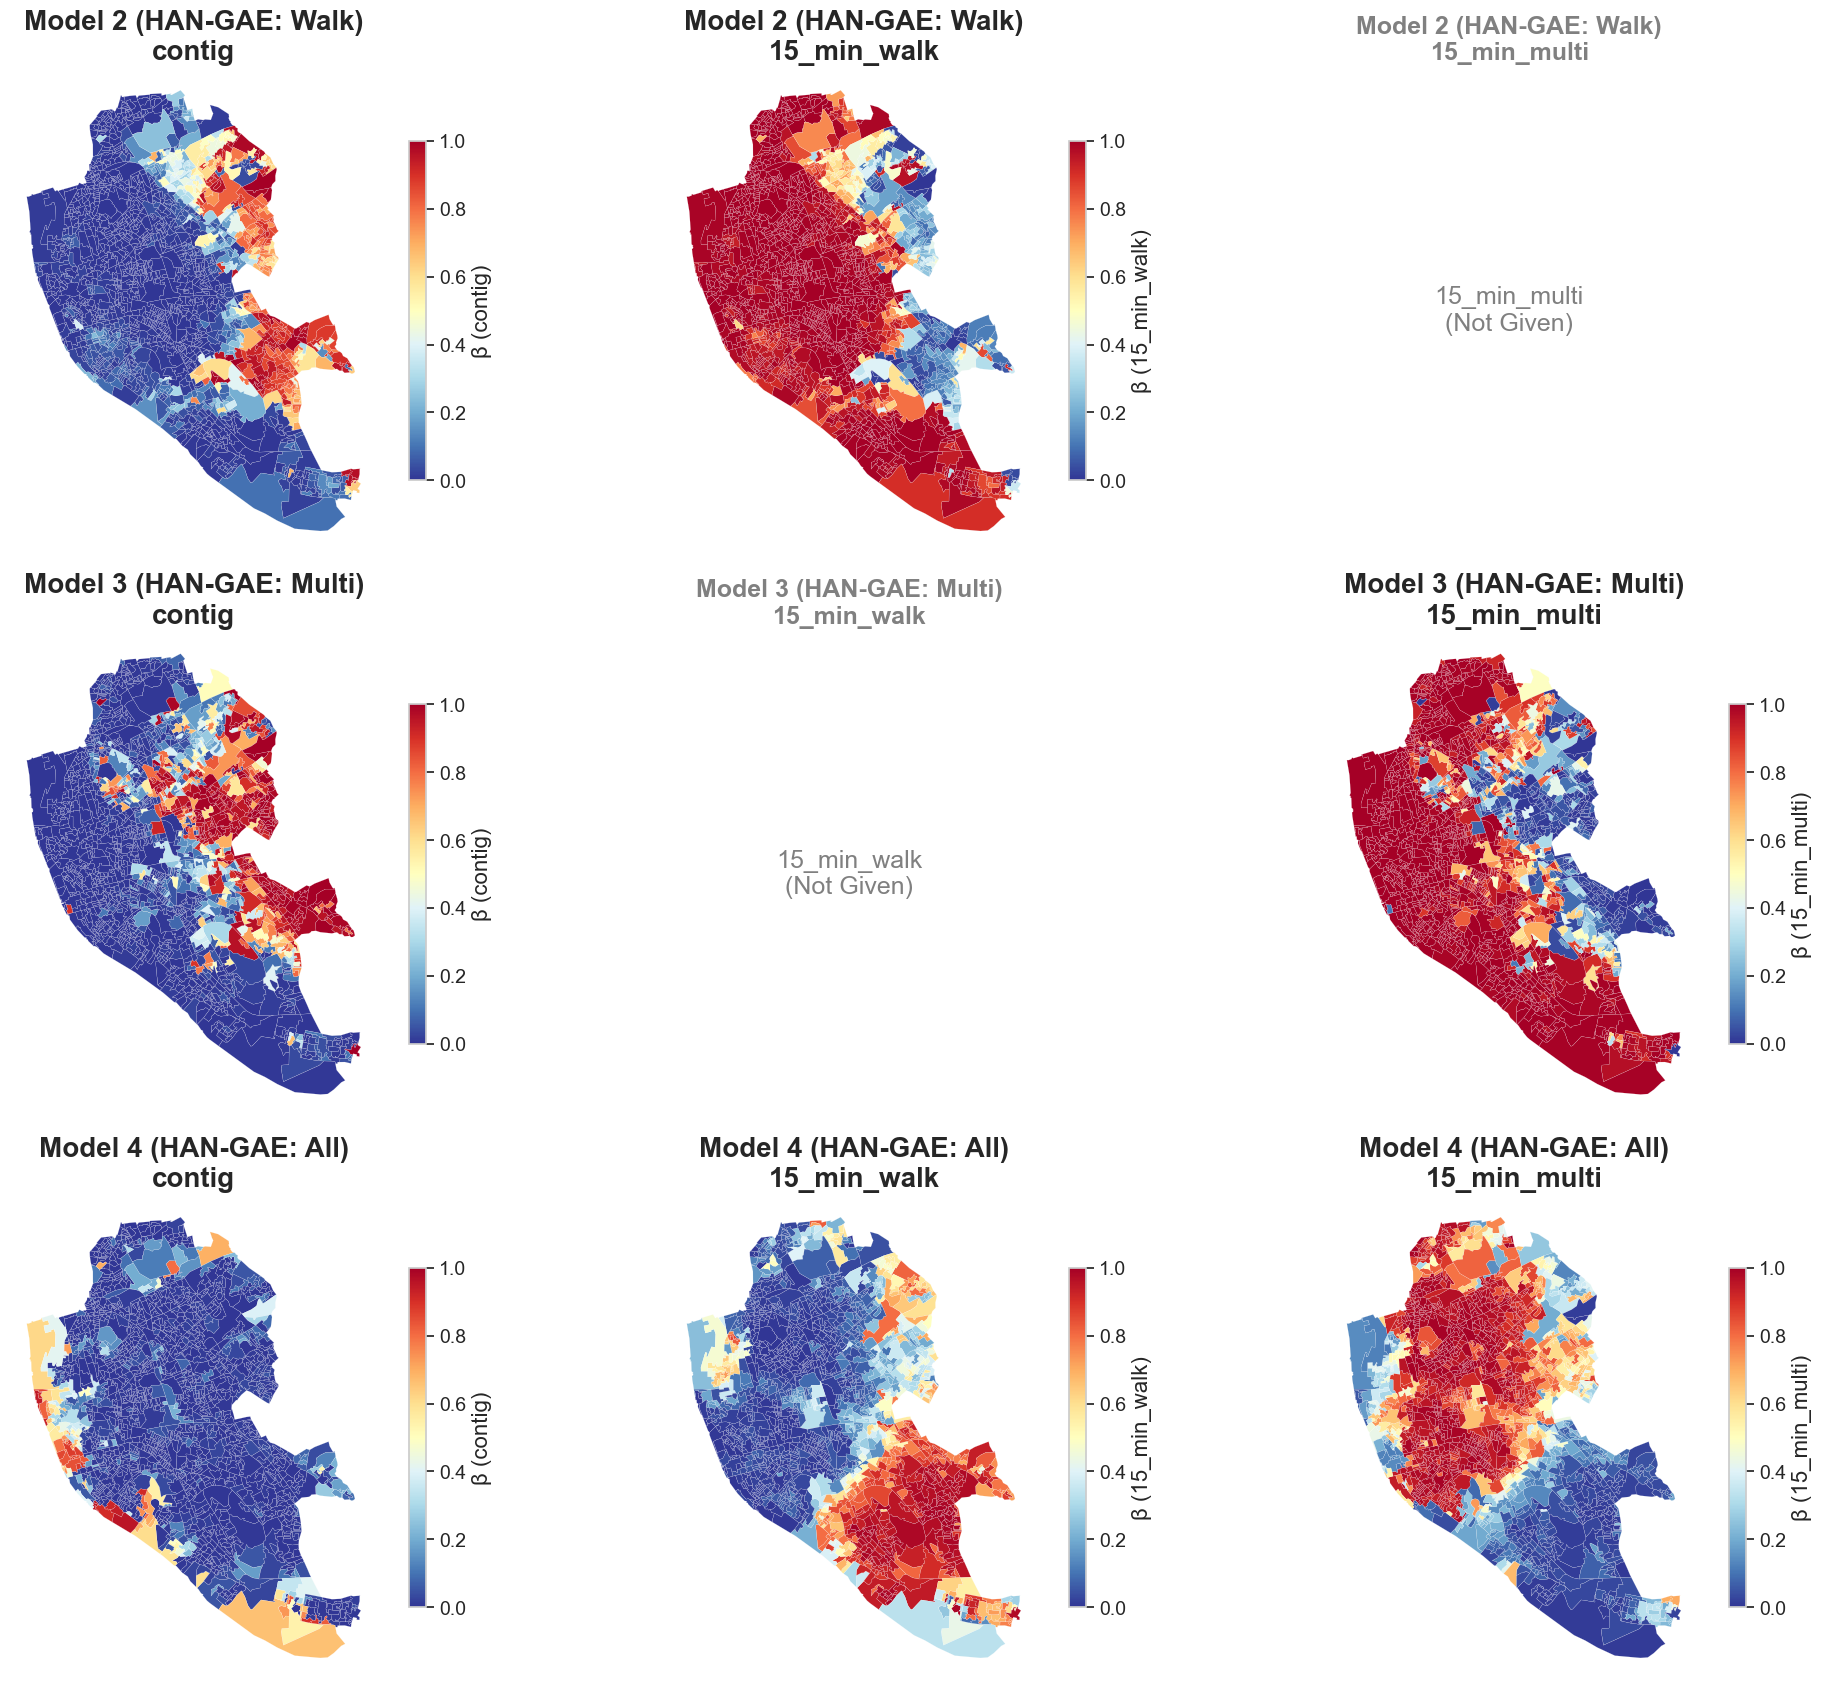

Saved Layer 2 plot to ../data/outputs/figures/attention_weight_layer_2.png


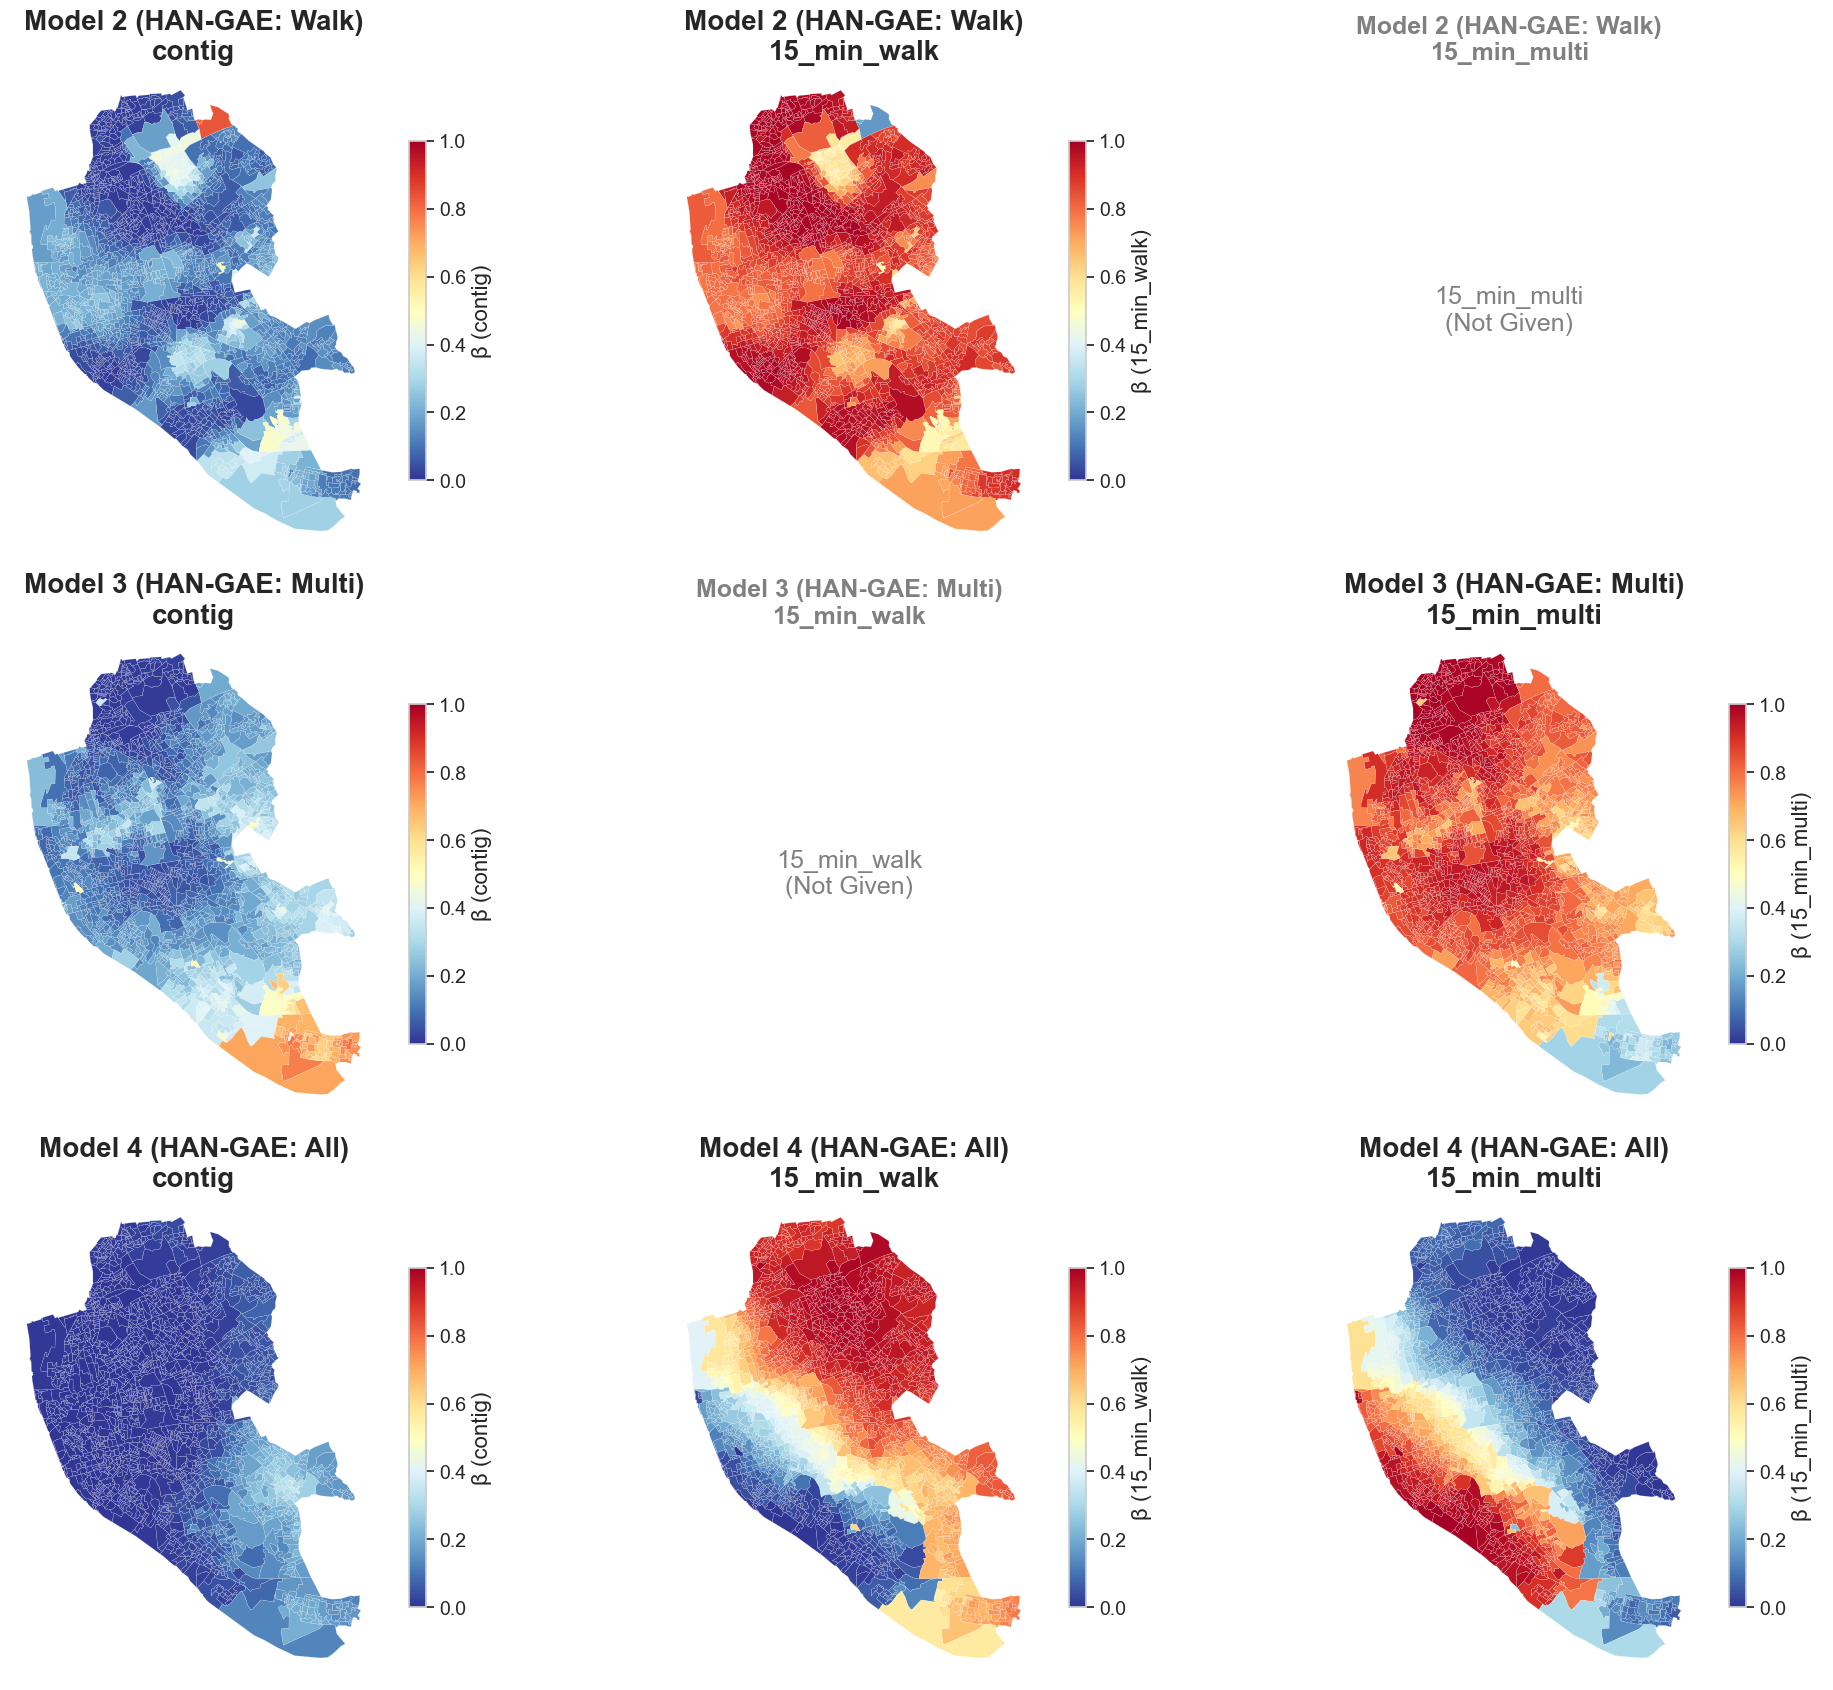

In [11]:
# Panel of all beta (attention) heatmaps for all HAN models
# Create separate 3x3 plots for Layer 1 and Layer 2
han_models = ['Model 2 (HAN-GAE: Walk)', 'Model 3 (HAN-GAE: Multi)', 'Model 4 (HAN-GAE: All)']
all_relations = ['contig', '15_min_walk', '15_min_multi']
layers = ['Layer 1', 'Layer 2']

for layer in layers:
    # 3 Rows (Models) x 3 Columns (Relations)
    fig, axes = plt.subplots(len(han_models), len(all_relations), figsize=(20, 18))
    
    for row_idx, model_name in enumerate(han_models):
        model_relations = RELATION_NAMES[model_name]
        gdf = model_gdfs[model_name].copy()
        beta_df = attention_data[model_name][layer]
        
        for col_idx, rel in enumerate(all_relations):
            ax = axes[row_idx, col_idx]
            
            if rel in model_relations:
                # This relation exists for this model
                beta_values = beta_df[rel].values
                # Force color mapping to 0-1 scale
                node_colors, _, _ = map_continuous_to_colors(beta_values, cmap_name='RdYlBu_r', vmin=0, vmax=1)
                
                c2g.plot_graph(
                    nodes=gdf,
                    ax=ax,
                    node_color=node_colors,
                    node_edgecolor='white',
                    node_alpha=1,
                    linewidth=0.1,
                    bgcolor='white',
                )
                
                # Add colorbar with fixed 0-1 scale
                sm = plt.cm.ScalarMappable(cmap='RdYlBu_r', norm=plt.Normalize(vmin=0, vmax=1))
                sm.set_array([])
                cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
                cbar.set_label(f'β ({rel})', fontsize=16)
                cbar.ax.tick_params(labelsize=14)
                
                ax.set_title(f"{model_name}\n{rel}", fontsize=20, fontweight='bold')
            else:
                # This relation does not exist for this model - show placeholder
                ax.text(0.5, 0.5, f'{rel}\n(Not Given)', 
                        ha='center', va='center', fontsize=18, color='gray',
                        transform=ax.transAxes)
                ax.set_facecolor('#f0f0f0')
                ax.set_title(f"{model_name}\n{rel}", fontsize=18, fontweight='bold', color='gray')
            
            ax.set_axis_off()
            
    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust for suptitle
    save_path = f"{FIGURES_DIR}/attention_weight_{layer.lower().replace(' ', '_')}.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved {layer} plot to {save_path}")
    plt.show()

## 8. t-SNE Embedding Visualization

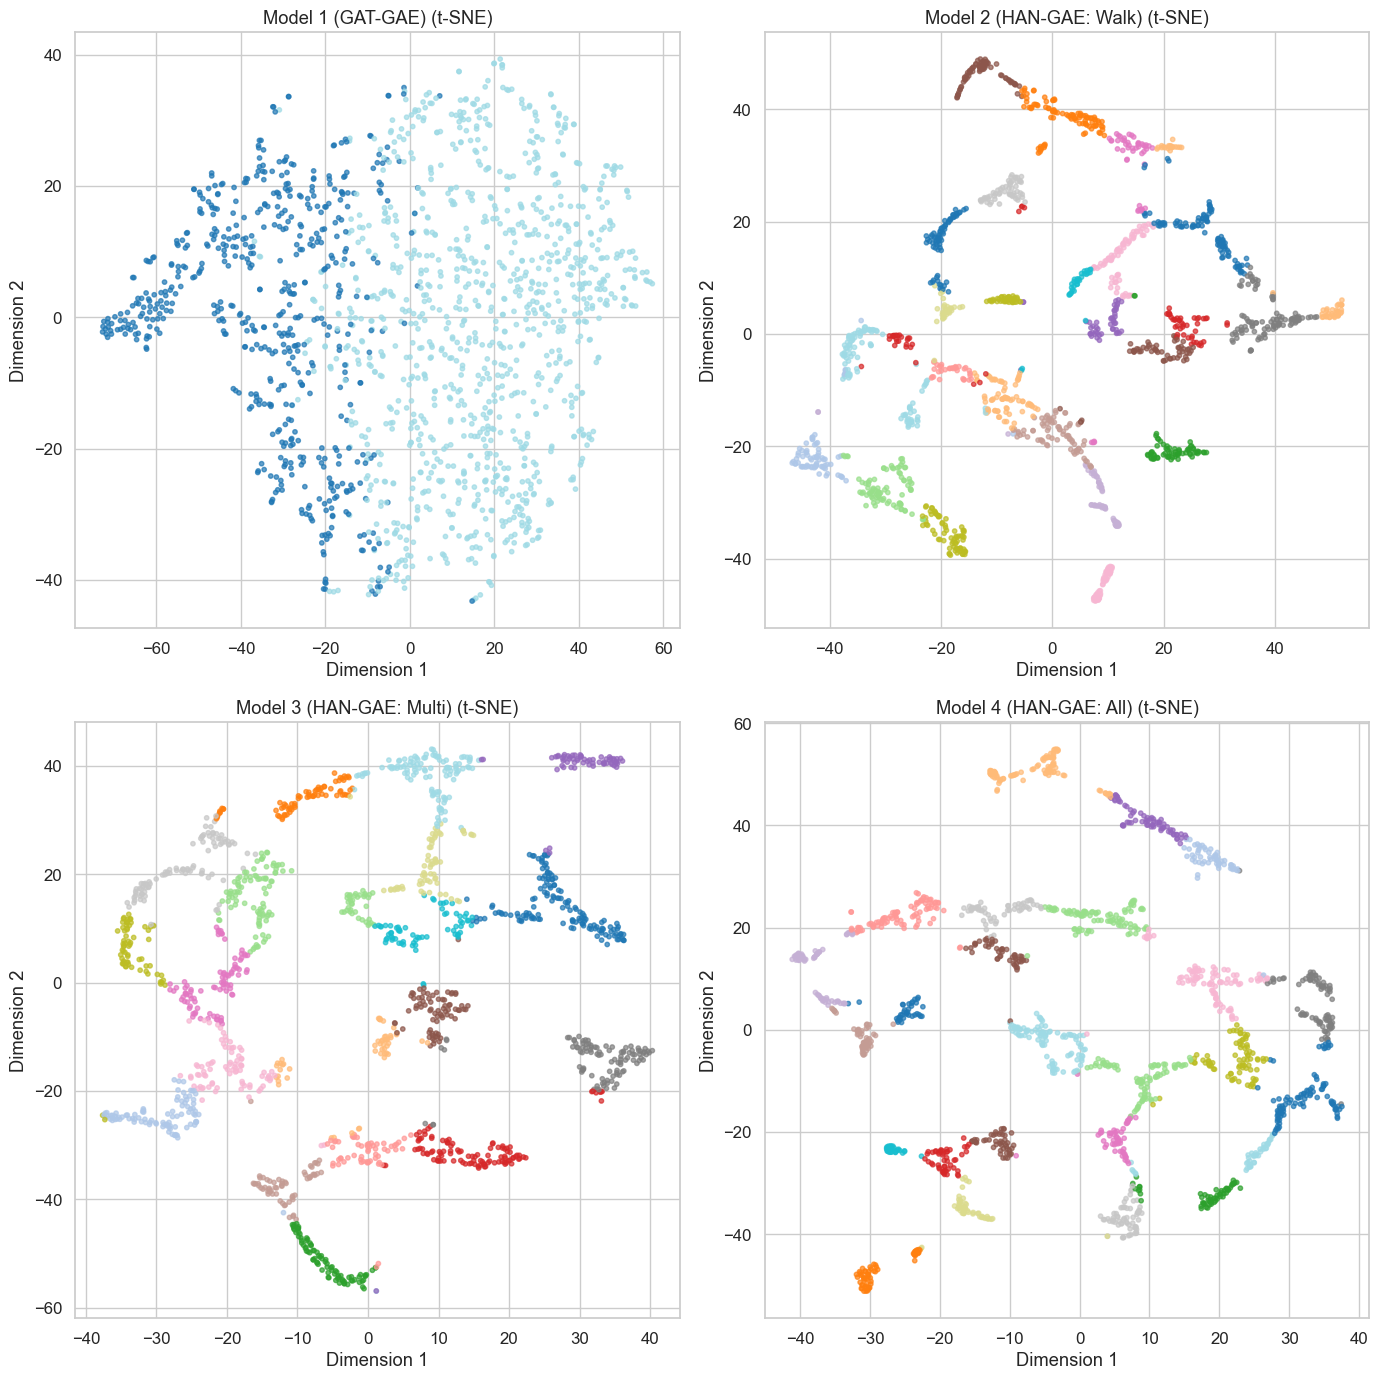

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

for idx, model_name in enumerate(models_to_plot):
    ax = axes[idx // 2, idx % 2]
    gdf = model_gdfs[model_name]
    Z = get_embeddings(gdf, MODELS[model_name]['type'])

    tsne = TSNE(n_components=2, perplexity=30, random_state=config['seeds']['tsne'])
    Z_2d = tsne.fit_transform(Z)

    scatter = ax.scatter(Z_2d[:, 0], Z_2d[:, 1], c=gdf['cluster'], 
                         cmap='tab20', s=10, alpha=0.7)
    ax.set_title(f"{model_name} (t-SNE)")
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/tsne_embeddings.png", dpi=150, bbox_inches='tight')
plt.show()

## 9. Isochrone Analysis

Generate isochrones from Liverpool ONE using the Baseline graph.

In [13]:
WALKING_SPEED_MPS = 4.8 / 3.6  # 4.8 km/h in m/s

# Load Baseline Graph (contains full network structure)
data = torch.load('../data/processed/graphs/hetero_multi.pt', map_location='cpu', weights_only=False)

# Convert to dict of GeoDataFrames
nodes, edges = c2g.pyg_to_gdf(data)

# Filter edges to keep only the ones we're interested in
edge_types_to_keep = [
    ('bus_station', 'is_nearby', 'street_connector'),
    ('street_connector', 'is_connected_to', 'street_connector'),
    ('bus_station', 'is_next_to', 'bus_station')
]
edges = {k: edges[k] for k in edge_types_to_keep if k in edges}

In [14]:
# Liverpool ONE coordinates
center_point = gpd.GeoSeries(Point(CITY_CENTRE['lon'], CITY_CENTRE['lat']), crs=4326).to_crs(nodes["oa"].crs)

# Define travel times and colors
travel_times = [i for i in range(5, 35, 5)]  # minutes
travel_times_sorted = sorted(travel_times, reverse=True)

iso_gdfs_walk = {}
iso_gdfs_multi = {}

for i, mins in enumerate(travel_times_sorted):
    threshold = mins * 60
    
    # 1. Walk Isochrone
    iso_walk = c2g.create_isochrone(
        nodes=nodes,
        edges={d:k for d,k in edges.items() if d in [('street_connector', 'is_connected_to', 'street_connector')]},
        center_point=center_point,
        threshold=threshold, 
        edge_attr='travel_time_sec',
        method="concave_hull_knn",
        k=50
    )
    iso_gdfs_walk[mins] = iso_walk
    
    # 2. Multi Isochrone
    iso_multi = c2g.create_isochrone(
        nodes=nodes,
        edges=edges,
        center_point=center_point,
        threshold=threshold, 
        edge_attr='travel_time_sec',
        cut_edge_types=[('bus_station', 'is_next_to', 'bus_station')],
        method="concave_hull_knn",
        k=50
    )
    iso_gdfs_multi[mins] = iso_multi

In [15]:
# Use a specific colormap
cmap = cm.get_cmap('RdYlBu_r')

# Generate colors for the sorted times (so longest time gets one color, shortest another)
colors = [cmap(i) for i in np.linspace(0, 1, len(travel_times))]
palette = colors

/var/folders/_n/l2f9tkgn3g17dj7hnsjprssc0000gn/T/ipykernel_11894/158372974.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlBu_r')


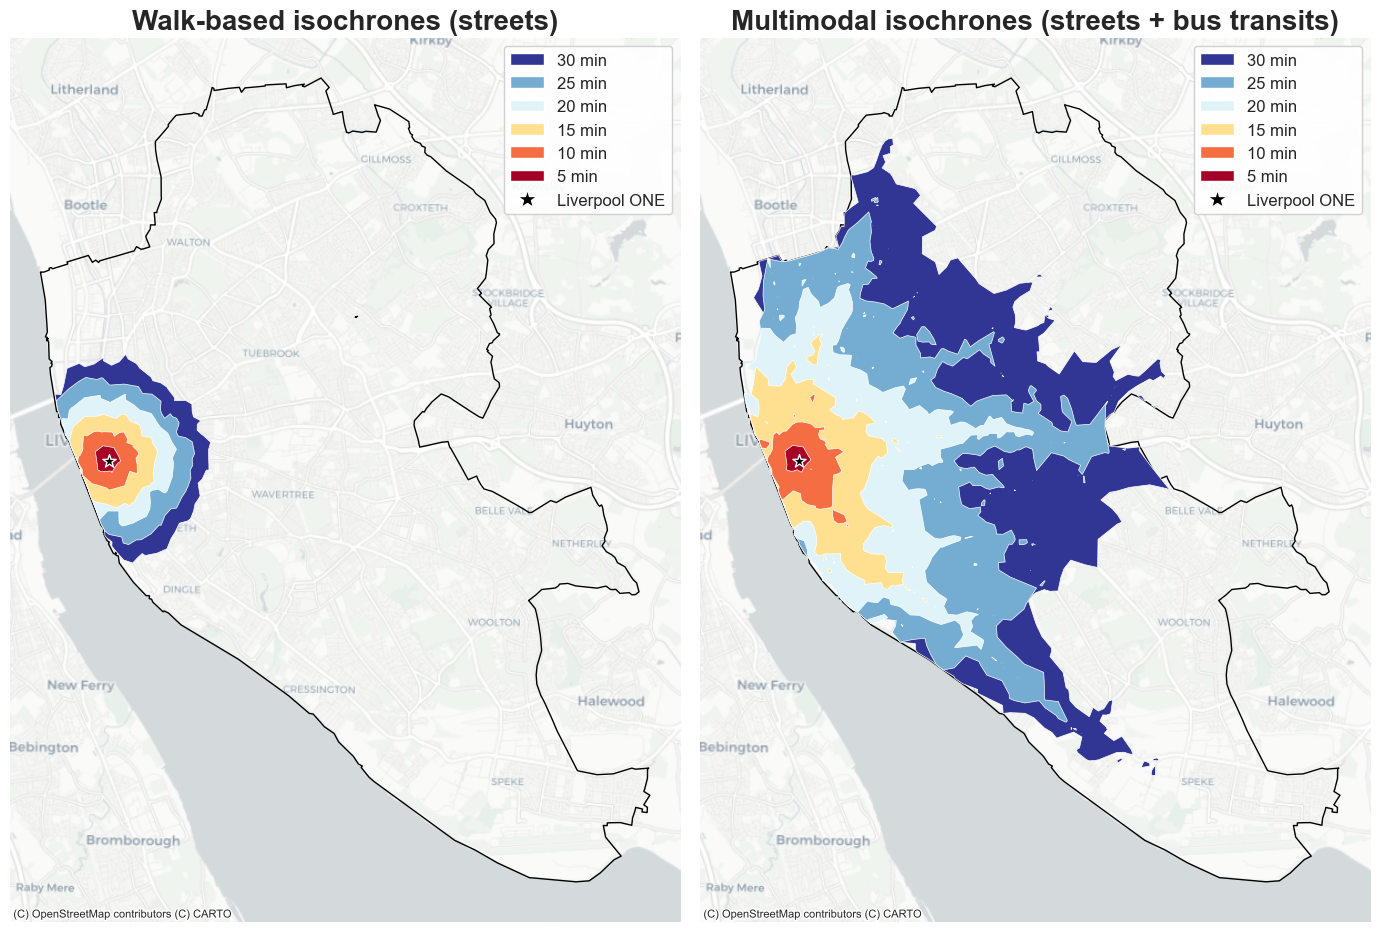

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 10))

# Helper to plot isochrones on an axis
def plot_isos(ax, iso_dict, title):
    # Plot background
    gpd.GeoSeries([oa_polygons.union_all()]).plot(ax=ax, facecolor="none", edgecolor='black')
    
    legend_elements = []
    
    # Iterate through sorted times (largest first to plot at bottom)
    for i, mins in enumerate(travel_times_sorted):
        if mins in iso_dict:
            gdf = iso_dict[mins]
            # Plot
            gdf.plot(ax=ax, color=palette[i], alpha=1, edgecolor='white', linewidth=0.5, zorder=1)
            # Legend entry (match alpha=1 from plot)
            legend_elements.append(Patch(facecolor=palette[i], edgecolor='white', label=f'{mins} min'))
            
    # Plot center point
    center_point.plot(ax=ax, color='black', marker='*', markersize=100, zorder=10, edgecolor='white')
    legend_elements.append(Line2D([0], [0], marker='*', color='w', label='Liverpool ONE', 
                                  markerfacecolor='black', markersize=15, markeredgecolor='white'))
    
    contextily.add_basemap(ax, crs=nodes["oa"].crs, source=contextily.providers.CartoDB.Positron, zoom=12)
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12, frameon=True, framealpha=0.9)
    ax.set_title(title, fontsize=20, fontweight='bold')
    ax.set_axis_off()

# Plot both
plot_isos(axes[0], iso_gdfs_walk, "Walk-based isochrones (streets)")
plot_isos(axes[1], iso_gdfs_multi, "Multimodal isochrones (streets + bus transits)")

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'isochrones.png'), dpi=200, bbox_inches='tight')
plt.show()

## 10. Isochrone-grounded interpretation (0–30 min, walk vs multimodal)

This section links embedding similarity, semantic attention, and clustering to walk vs multimodal accessibility rings (0–15, 15–30, 30+ min) and evaluates a 2-hop diagnostic for the 15-min relations.

In [17]:
# Travel time bins from isochrone polygons (walk vs multi)
from shapely import wkt

def build_min_time_from_isochrones(oa_points, iso_dict):
    """
    Compute minimum isochrone time (minutes) for each OA point using polygons.
    iso_dict: {minutes: GeoDataFrame}
    """
    if not iso_dict:
        return pd.Series(np.inf, index=oa_points.index), []
    times = sorted(int(k) for k in iso_dict.keys())
    min_time = pd.Series(np.inf, index=oa_points.index, dtype=float)
    for t in times:
        geom = iso_dict[t].geometry.union_all()
        within = oa_points.within(geom)
        min_time[within & (min_time > t)] = t
    return min_time, times


oa_points = gpd.GeoSeries(
    oa_polygons['pop_weighted_centroid'].apply(wkt.loads),
    crs=oa_polygons.crs
    )

# Compute minimum reachable minutes using isochrone polygons
t_walk_min, walk_times = build_min_time_from_isochrones(oa_points, iso_gdfs_walk)
t_multi_min, multi_times = build_min_time_from_isochrones(oa_points, iso_gdfs_multi)

# Standard bins (minutes) for decay curves
bins = [0, 5, 10, 15, 20, 25, 30, np.inf]
labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '>30'] 

# Bin assignments using polygon-derived minimum times
t_walk_bin = pd.cut(t_walk_min, bins=bins, labels=labels, include_lowest=True)
t_multi_bin = pd.cut(t_multi_min, bins=bins, labels=labels, include_lowest=True)

/var/folders/_n/l2f9tkgn3g17dj7hnsjprssc0000gn/T/ipykernel_11894/3659674000.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decay_df.groupby(['Model', 'Mode', 'time_bin'])['similarity']


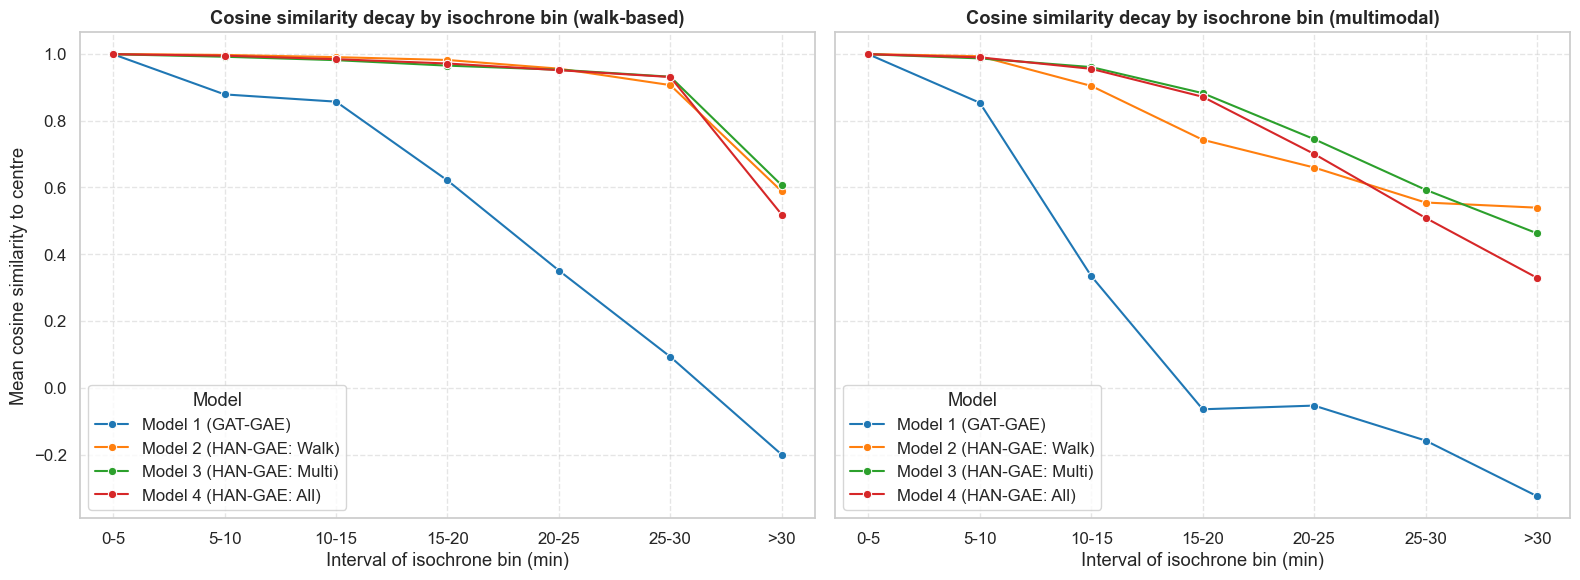

In [18]:
# Decay curves (cosine similarity vs isochrone bins)
import seaborn as sns

decay_records = []
models_for_decay = ['Model 1 (GAT-GAE)', 'Model 2 (HAN-GAE: Walk)', 'Model 3 (HAN-GAE: Multi)', 'Model 4 (HAN-GAE: All)']

for model_name in models_for_decay:
    gdf = model_gdfs[model_name]
    Z = get_embeddings(gdf, MODELS[model_name]['type'])
    Z_norm = normalize(Z, norm='l2')
    sims = compute_embedding_similarity_to_centre(Z_norm, gdf.index, centre_oa_idx)
    
    # Walk bins from isochrone polygons
    df_walk = pd.DataFrame({
        'Model': model_name,
        'Mode': 'walk-based',
        'time_bin': t_walk_bin.loc[gdf.index].values,
        'similarity': sims
    })
    decay_records.append(df_walk)
    
    # Multi bins from isochrone polygons
    df_multi = pd.DataFrame({
        'Model': model_name,
        'Mode': 'multimodal',
        'time_bin': t_multi_bin.loc[gdf.index].values,
        'similarity': sims
    })
    decay_records.append(df_multi)

decay_df = pd.concat(decay_records, ignore_index=True)
decay_df['time_bin'] = pd.Categorical(decay_df['time_bin'], categories=labels, ordered=True)

# Aggregate mean similarity per bin
decay_summary = (
    decay_df.groupby(['Model', 'Mode', 'time_bin'])['similarity']
    .mean()
    .reset_index()
    .dropna()
 )

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
for ax, mode in zip(axes, ['walk-based', 'multimodal']):
    sub = decay_summary[decay_summary['Mode'] == mode]
    sns.lineplot(data=sub, x='time_bin', y='similarity', hue='Model', marker='o', ax=ax)
    ax.set_title(f'Cosine similarity decay by isochrone bin ({mode})', fontweight='bold')
    ax.set_xlabel('Interval of isochrone bin (min)')
    ax.set_ylabel('Mean cosine similarity to centre')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(title='Model', loc='lower left')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'similarity_decay_by_time_bin.png'), dpi=200, bbox_inches='tight')
plt.show()

decay_summary.to_csv(os.path.join(TABLES_DIR, 'similarity_decay_by_time_bin.csv'), index=False)

In [19]:
decay_summary

Model        Mode time_bin  similarity
0          Model 1 (GAT-GAE)  multimodal      0-5    0.999098
1          Model 1 (GAT-GAE)  multimodal     5-10    0.853662
2          Model 1 (GAT-GAE)  multimodal    10-15    0.334610
3          Model 1 (GAT-GAE)  multimodal    15-20   -0.064300
4          Model 1 (GAT-GAE)  multimodal    20-25   -0.053265
5          Model 1 (GAT-GAE)  multimodal    25-30   -0.157974
6          Model 1 (GAT-GAE)  multimodal      >30   -0.324485
7          Model 1 (GAT-GAE)  walk-based      0-5    0.999098
8          Model 1 (GAT-GAE)  walk-based     5-10    0.878803
9          Model 1 (GAT-GAE)  walk-based    10-15    0.857094
10         Model 1 (GAT-GAE)  walk-based    15-20    0.621077
11         Model 1 (GAT-GAE)  walk-based    20-25    0.351344
12         Model 1 (GAT-GAE)  walk-based    25-30    0.092888
13         Model 1 (GAT-GAE)  walk-based      >30   -0.200198
14   Model 2 (HAN-GAE: Walk)  multimodal      0-5    0.999714
15   Model 2 (HAN-GAE: Walk)  multimodal     5-10    0.993081
16   Model 2 (HAN-GAE: Walk)  multimodal    10-15    0.904187
17   Model 2 (HAN-GAE: Walk)  multimodal    15-20    0.742895
18   Model 2 (HAN-GAE: Walk)  multimodal    20-25    0.659806
19   Model 2 (HAN-GAE: Walk)  multimodal    25-30    0.554992
20   Model 2 (HAN-GAE: Walk)  multimodal      >30    0.539562
21   Model 2 (HAN-GAE: Walk)  walk-based      0-5    0.999714
22   Model 2 (HAN-GAE: Walk)  walk-based     5-10    0.996988
23   Model 2 (HAN-GAE: Walk)  walk-based    10-15    0.990422
24   Model 2 (HAN-GAE: Walk)  walk-based    15-20    0.981874
25   Model 2 (HAN-GAE: Walk)  walk-based    20-25    0.955937
26   Model 2 (HAN-GAE: Walk)  walk-based    25-30    0.906652
27   Model 2 (HAN-GAE: Walk)  walk-based      >30    0.588579
28  Model 3 (HAN-GAE: Multi)  multimodal      0-5    0.999059
29  Model 3 (HAN-GAE: Multi)  multimodal     5-10    0.986684
30  Model 3 (HAN-GAE: Multi)  multimodal    10-15    0.960644
31  Model 3 (HAN-GAE: Multi)  multimodal    15-20    0.882565
32  Model 3 (HAN-GAE: Multi)  multimodal    20-25    0.744860
33  Model 3 (HAN-GAE: Multi)  multimodal    25-30    0.593273
34  Model 3 (HAN-GAE: Multi)  multimodal      >30    0.462839
35  Model 3 (HAN-GAE: Multi)  walk-based      0-5    0.999059
36  Model 3 (HAN-GAE: Multi)  walk-based     5-10    0.991615
37  Model 3 (HAN-GAE: Multi)  walk-based    10-15    0.981397
38  Model 3 (HAN-GAE: Multi)  walk-based    15-20    0.964979
39  Model 3 (HAN-GAE: Multi)  walk-based    20-25    0.952714
40  Model 3 (HAN-GAE: Multi)  walk-based    25-30    0.931740
41  Model 3 (HAN-GAE: Multi)  walk-based      >30    0.606495
42    Model 4 (HAN-GAE: All)  multimodal      0-5    0.999137
43    Model 4 (HAN-GAE: All)  multimodal     5-10    0.989749
44    Model 4 (HAN-GAE: All)  multimodal    10-15    0.955399
45    Model 4 (HAN-GAE: All)  multimodal    15-20    0.871671
46    Model 4 (HAN-GAE: All)  multimodal    20-25    0.700494
47    Model 4 (HAN-GAE: All)  multimodal    25-30    0.509010
48    Model 4 (HAN-GAE: All)  multimodal      >30    0.329515
49    Model 4 (HAN-GAE: All)  walk-based      0-5    0.999137
50    Model 4 (HAN-GAE: All)  walk-based     5-10    0.994805
51    Model 4 (HAN-GAE: All)  walk-based    10-15    0.984304
52    Model 4 (HAN-GAE: All)  walk-based    15-20    0.971341
53    Model 4 (HAN-GAE: All)  walk-based    20-25    0.951382
54    Model 4 (HAN-GAE: All)  walk-based    25-30    0.930888
55    Model 4 (HAN-GAE: All)  walk-based      >30    0.518769